In [10]:
from SAPSII_computation import compute_sapsii
from SAPSII_computation import compute_sofa
import matplotlib.pyplot as plt
import pandas as pd
# load admission, patients, labevents, chartevents
admissions = pd.read_csv("../data/ADMISSIONS.csv")
patients = pd.read_csv("../data/PATIENTS.csv")

In [11]:
# # record original admission count before filtering
# original_admissions_count = admissions.shape[0]
# # parse discharge and death times for filtering
admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'])
admissions['DEATHTIME'] = pd.to_datetime(admissions['DEATHTIME'], errors='coerce')

died = admissions.loc[
    admissions['DEATHTIME'].notna() &
    (admissions['DEATHTIME'] <= admissions['DISCHTIME']),
    'HADM_ID'
]
print(f"{len(died)} admissions ended in in-hospital death")
died.to_csv("died_hadms.csv", index=False)


5816 admissions ended in in-hospital death


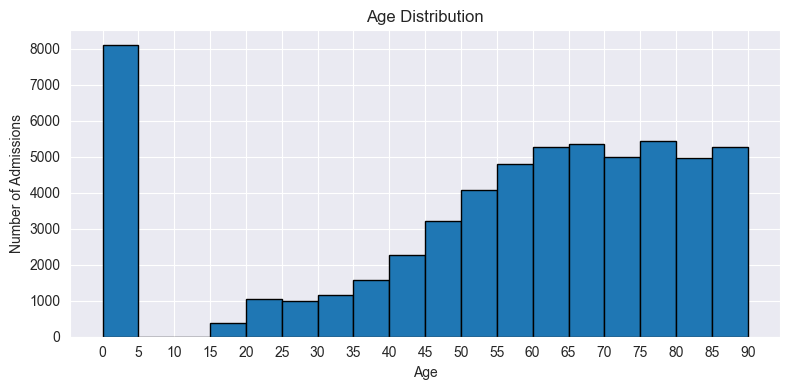

In [12]:
# demographics: age, gender
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
# compute hospital length of stay in hours
admissions['hospital_los_hours'] = (
    admissions['DISCHTIME'] - admissions['ADMITTIME']
).dt.total_seconds() / 3600
patients['DOB']         = pd.to_datetime(patients['DOB'])

df = (
    admissions[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'hospital_los_hours']]
    .merge(patients[['SUBJECT_ID', 'DOB', 'GENDER']], on='SUBJECT_ID', how='left')
)

# calculate age
df['AGE'] = df['ADMITTIME'].dt.year - df['DOB'].dt.year

mask = (
    (df['ADMITTIME'].dt.month  < df['DOB'].dt.month) |
    ((df['ADMITTIME'].dt.month == df['DOB'].dt.month) &
     (df['ADMITTIME'].dt.day   < df['DOB'].dt.day))
)
df.loc[mask, 'AGE'] -= 1

# cap at 90 per MIMIC policy
df.loc[df['AGE'] > 89, 'AGE'] = 90

age = df.set_index('SUBJECT_ID')['AGE']

plt.figure(figsize=(8,4))
plt.hist(df['AGE'], bins=range(0, 95, 5), edgecolor='black')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Number of Admissions")
plt.xticks(range(0, 95, 5))
plt.tight_layout()
plt.show()

In [13]:
# drop less 18
df = df[df['AGE'] > 18].copy()
filtered_df_count = df.shape[0]
print('remaining admissions after filtering age:', filtered_df_count)
# Counts by each age
# Summary statistics
print(df['AGE'].describe())

remaining admissions after filtering age: 50631
count    50631.000000
mean        63.615255
std         17.057059
min         19.000000
25%         52.000000
50%         65.000000
75%         77.000000
max         90.000000
Name: AGE, dtype: float64


In [14]:
gender = df.set_index('SUBJECT_ID')['GENDER']
print(gender.head())
# chart values
chart_agg = pd.read_csv('chart_stats_24h_vs_stay.csv')
# lab values
# lab_agg = pd.read_csv('lab_values.csv')
# cpt values
cpt_features = pd.read_csv('cpt_values.csv')
# urine values
urine_agg = pd.read_csv('output_values.csv')
# ICD 9 code
diag_agg = pd.read_csv("diag_features.csv")
# proc_agg = pd.read_csv("proc_topic_counts.csv")
# ICU stay
icu_agg = pd.read_csv("icu_features.csv")
# prepare the feature data frame
demo_feats = (
    df[['HADM_ID','SUBJECT_ID', 'AGE', 'GENDER', 'hospital_los_hours']]
    .drop_duplicates(subset='HADM_ID')
    .set_index('HADM_ID')
)
# lab_agg = lab_agg.dropna(subset=['HADM_ID']).set_index('HADM_ID')
chart_agg = chart_agg.dropna(subset=['HADM_ID']).set_index('HADM_ID')
urine_agg = urine_agg.dropna(subset=['HADM_ID']).set_index('HADM_ID')
cpt_features = cpt_features.dropna(subset=['HADM_ID']).set_index('HADM_ID')
diag_agg = diag_agg.dropna(subset=['HADM_ID']).set_index('HADM_ID')
# proc_agg = proc_agg.dropna(subset=['HADM_ID']).set_index('HADM_ID')
icu_agg = icu_agg.dropna(subset=['HADM_ID']).set_index('HADM_ID')
feature_df = (
    demo_feats
      # .join(lab_agg, how='left')
      .join(chart_agg, how='left')
      .join(urine_agg, how='left')
      .join(cpt_features, how='left')
      .join(diag_agg, how='left')
      # .join(proc_agg, how='left')
      .join(icu_agg, how='left')
      .reset_index()
)
# inspect missingness per feature before dropping rows
missing_counts = feature_df.isna().sum()
missing_pct = missing_counts / feature_df.shape[0]
missing_df = pd.DataFrame({
    'feature': missing_counts.index,
    'missing_count': missing_counts.values,
    'missing_pct': missing_pct.values
})
missing_df = missing_df.sort_values(by='missing_count', ascending=False)
print("Top features by number of missing values:")
print(missing_df.head(10))


SUBJECT_ID
22    F
23    M
23    M
24    M
25    M
Name: GENDER, dtype: object
Top features by number of missing values:
              feature  missing_count  missing_pct
83   urine_output_24h          31093     0.614110
178             32220          23974     0.473504
230             36489          23974     0.473504
238             37205          23974     0.473504
237             37195          23974     0.473504
236             36800          23974     0.473504
235             36620          23974     0.473504
234             36600          23974     0.473504
233             36580          23974     0.473504
232             36558          23974     0.473504


In [15]:
# drop admissions with >30% missing features
all_hadms = feature_df['HADM_ID'].tolist()
original_feature_count = len(all_hadms)

# 2) compute your keep-mask
max_missing = int(0.8 * feature_df.shape[1])
keep_mask = feature_df.isna().sum(axis=1) <= max_missing

# 3) capture the dropped HADM_IDs for later use
dropped_hadm_ids = feature_df.loc[~keep_mask, 'HADM_ID'].tolist()
print(f"Will drop {len(dropped_hadm_ids)} stays: {dropped_hadm_ids[:10]} ...")

# 4) apply the filter
feature_df = feature_df[keep_mask].copy()
dropped_count = original_feature_count - feature_df.shape[0]
print(f"Dropped {dropped_count} admissions with >30% missing features "
      f"(>{max_missing} missing of {feature_df.shape[1]} columns)")

# 5) (Optional) save the list of dropped IDs for later readmission checks
pd.DataFrame({'HADM_ID': dropped_hadm_ids}).to_csv("dropped_hadms.csv", index=False)

Will drop 4903 stays: [188670.0, 148959.0, 176332.0, 189535.0, 195961.0, 186474.0, 155252.0, 158569.0, 120969.0, 166401.0] ...
Dropped 4903 admissions with >30% missing features (>284 missing of 356 columns)


In [16]:
# vital signs computation
print("compute SAPS II for each admission")
feature_df['SAPSII'] = feature_df.apply(compute_sapsii, axis=1)
print("compute SOFA for each admission")
feature_df['SOFA'] = feature_df.apply(compute_sofa, axis=1)
print(feature_df.shape)
print(feature_df.columns)
print(feature_df.sample())

# target dataframe
adm_counts = (
    admissions
      .groupby("SUBJECT_ID")["HADM_ID"]
      .nunique()
      .reset_index(name="n_admissions")
)

# 2. Filter to patients with >1 admissions & drop outlier
p99 = adm_counts["n_admissions"].quantile(0.99)
multi_adm = adm_counts[
    (adm_counts["n_admissions"] > 1) &
    (adm_counts["n_admissions"] <= p99)
].copy()

print(f"99th percentile cutoff = {p99:.0f} admissions")
print(multi_adm)

admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'])
# sort with order
admissions = admissions.sort_values(['SUBJECT_ID', 'ADMITTIME'])
admissions['next_admittime'] = (
    admissions
      .groupby('SUBJECT_ID')['ADMITTIME']
      .shift(-1)
)
admissions['readmit_gap'] = (
    admissions['next_admittime'] - admissions['DISCHTIME']
).dt.days
admissions['readmission_30'] = (
    admissions['readmit_gap']
      .between(1, 30)
      .fillna(0)
      .astype(int)
)
admissions['readmission_60'] = (
    admissions['readmit_gap']
      .between(1, 60)        # 1–60 days
      .astype(int)
)
admissions['n_admissions'] = (
    admissions.groupby('SUBJECT_ID')['HADM_ID']
              .transform('nunique')
)
mask = (
    (admissions['n_admissions'] == 1) |
    (admissions['next_admittime'].notna())
)
# target_df = admissions.loc[mask,
#     ['SUBJECT_ID','HADM_ID','readmission_30','readmission_60']
# ].copy()
target_df = admissions.loc[mask, ['SUBJECT_ID','HADM_ID','readmission_30']].copy()
died = pd.read_csv("died_hadms.csv")['HADM_ID']
died_targets = target_df[target_df['HADM_ID'].isin(died)]
print(f"Of the {len(died)} in-hospital deaths, {died_targets['readmission_30'].sum()} have a 30-day readmit flag (should be zero).")
target_df = target_df.loc[~target_df['HADM_ID'].isin(died)].copy()
print(target_df.shape)
target_df.to_csv("target_hadms.csv", index=False)

compute SAPS II for each admission
compute SOFA for each admission
(45728, 358)
Index(['HADM_ID', 'SUBJECT_ID', 'AGE', 'GENDER', 'hospital_los_hours',
       'HeartRate_mean_24h', 'RespRate_mean_24h', 'SBP_mean_24h',
       'DBP_mean_24h', 'Temp_mean_24h',
       ...
       '99141', '99144', 'total_cpt_count', 'unique_diag_count', 'CCI',
       'num_icu_stays', 'mean_icu_los_hours', 'last_careunit', 'SAPSII',
       'SOFA'],
      dtype='object', length=358)
        HADM_ID  SUBJECT_ID  AGE GENDER  hospital_los_hours  \
39835  137771.0       68691   78      M          135.783333   

       HeartRate_mean_24h  RespRate_mean_24h  SBP_mean_24h  DBP_mean_24h  \
39835              93.875          18.729167    121.583333        70.125   

       Temp_mean_24h  ...  99141  99144  total_cpt_count  unique_diag_count  \
39835           96.4  ...    NaN    NaN              NaN                 25   

       CCI  num_icu_stays  mean_icu_los_hours  last_careunit  SAPSII  SOFA  
39835   13           

In [17]:
# # 1) Load the list of dropped HADM_IDs
# dropped = pd.read_csv("dropped_hadms.csv")['HADM_ID']
#
# # 2) Filter your target_df to just those dropped stays
# dropped_targets = target_df[target_df['HADM_ID'].isin(dropped)]
#
# # 3) Count how many of those had a 30-day readmission
# n_readm_dropped = dropped_targets['readmission_30'].sum()
# total_dropped = len(dropped)
#
# print(f"Among the {total_dropped} dropped admissions, {n_readm_dropped} had a 30-day readmission.")
# print(target_df.sample(10))

In [18]:
# prepare the final data frame
final_df = feature_df.merge(
    target_df[['HADM_ID','readmission_30']],
    on='HADM_ID',
    how='inner'
)
print(final_df.shape)
print(final_df[['HADM_ID','readmission_30']].head())
final_df.to_csv("../src/dataframe_clean.csv", index=False)

(35419, 359)
    HADM_ID  readmission_30
0  165315.0               0
1  152223.0               0
2  161859.0               0
3  129635.0               0
4  197661.0               0
